In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
!pip install pyclustertend
from pyclustertend import hopkins, vat, ivat

In [4]:
from scipy.spatial import ConvexHull
from scipy import interpolate

In [5]:
from itertools import combinations

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Data

In [7]:
# data
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/practices/data/industries.csv', index_col=0)
data_df.head()

,ind,l_19,trained_19,va_curr_19,va_const_10,va_const_19,invest_curr_19,fdi_value,enterprise_18
ind_code,,,,,,,,,
A,"Nông nghiệp, lâm nghiệp và thủy sản",18831.4,4.0,842601.0,396576.0,510632.0,119719.0,3518.1,6844.0
B,Khai khoáng,197.9,54.0,405797.0,204544.0,210464.0,44027.0,4897.5,3495.0
C,"Công nghiệp chế biến, chế tạo",11287.6,17.7,995126.0,279360.0,712447.0,559708.0,214610.4,96715.0
D,"Sản xuất và phân phối điện, khí đốt, nước nóng...",192.8,76.4,291464.0,65721.0,163085.0,152285.0,23653.8,1490.0
E,Cung cấp nước; hoạt động quản lý và xử lý rác ...,163.2,37.5,31190.0,11107.0,22162.0,29986.0,2857.4,2347.0


## Missing data

In [8]:
# check data types
data_df.dtypes

ind                object
l_19              float64
trained_19        float64
va_curr_19        float64
va_const_10       float64
va_const_19       float64
invest_curr_19    float64
fdi_value         float64
enterprise_18     float64
dtype: object

In [9]:
# missing data
data_df.isna().sum()

ind               0
l_19              0
trained_19        0
va_curr_19        1
va_const_10       1
va_const_19       1
invest_curr_19    2
fdi_value         3
enterprise_18     3
dtype: int64

In [10]:
# drop 2 last indexes & fill na
data_df.drop(['T', 'U'], axis=0, inplace=True)
data_df.fillna(0, inplace=True)

## Create new features

In [11]:
# calculate new features
# data_df['d_l'] = data_df['l_19'] - data_df['l_10'] # labor growth
# data_df['d_trained'] = data_df['trained_19'] - data_df['trained_10'] # increase of traind labor rate
# data_df['share_va'] = data_df['va_curr_19'] / np.sum(data_df['va_curr_19']) # VA share
data_df['d_va'] = data_df['va_const_19'] - data_df['va_const_10'] # VA growth
data_df['productivity'] = data_df['va_const_19'] / data_df['l_19'] # labor productivity
# data_df['share_d_va'] = (data_df['va_const_19'] - data_df['va_const_10']) / (np.sum(data_df['va_const_19']) - np.sum(data_df['va_const_10'])) # contribution in VA growth
# data_df['share_investment'] = data_df['investment_curr_19'] / np.sum(data_df['investment_curr_19']) # investment share
# data_df['d_investment'] = data_df['investment_const_19'] - data_df['investment_const_10'] # investment growth
# data_df['d_enterprise'] = data_df['enterprise_18'] - data_df['enterprise_10'] # increase of enterprises
# data_df['share_enterprise'] = data_df['enterprise_18'] / np.sum(data_df['enterprise_18']) # enterprises share

In [12]:
# drop features
data_df.drop(['ind', 'va_const_10', 'va_const_19'], axis=1, inplace=True)

print('data_df shape: {}'.format(data_df.shape))
data_df.head()

data_df shape: (19, 8)


,l_19,trained_19,va_curr_19,invest_curr_19,fdi_value,enterprise_18,d_va,productivity
ind_code,,,,,,,,
A,18831.4,4.0,842601.0,119719.0,3518.1,6844.0,114056.0,27.115987
B,197.9,54.0,405797.0,44027.0,4897.5,3495.0,5920.0,1063.486609
C,11287.6,17.7,995126.0,559708.0,214610.4,96715.0,433087.0,63.117669
D,192.8,76.4,291464.0,152285.0,23653.8,1490.0,97364.0,845.876556
E,163.2,37.5,31190.0,29986.0,2857.4,2347.0,11055.0,135.796569


## Scale data

In [13]:
# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_df)

# Visualize data
- Bar plot, scatter plot
- Hopkins statistic, VAT
- Dendrogram

## Simple plots

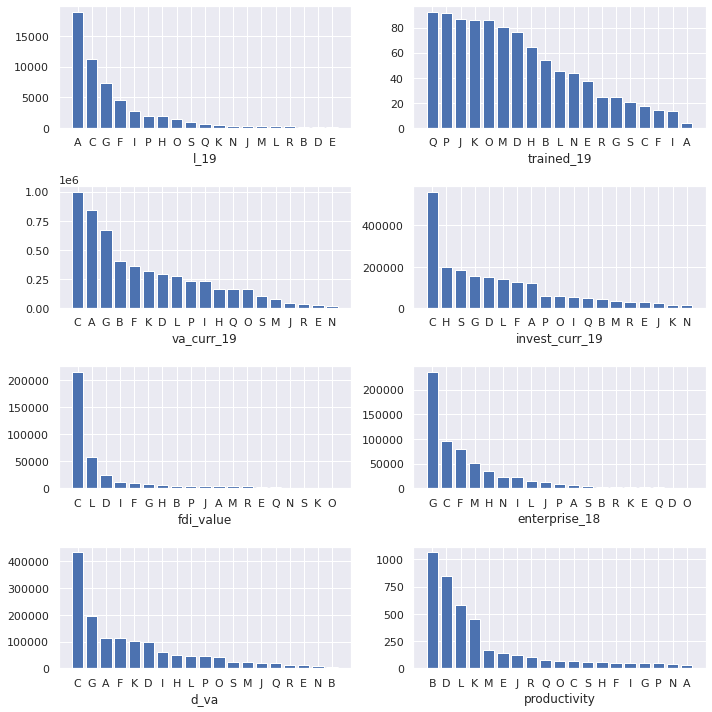

In [15]:
# 8 bar plots
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(10, 10)
)

for feature, ax in zip(data_df.columns, axes.flatten()):
    series = data_df[feature].sort_values(ascending=False)
    ax.bar(
        x=series.index,
        height=series
    )
    ax.set_xlabel(feature)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig1')
plt.show()

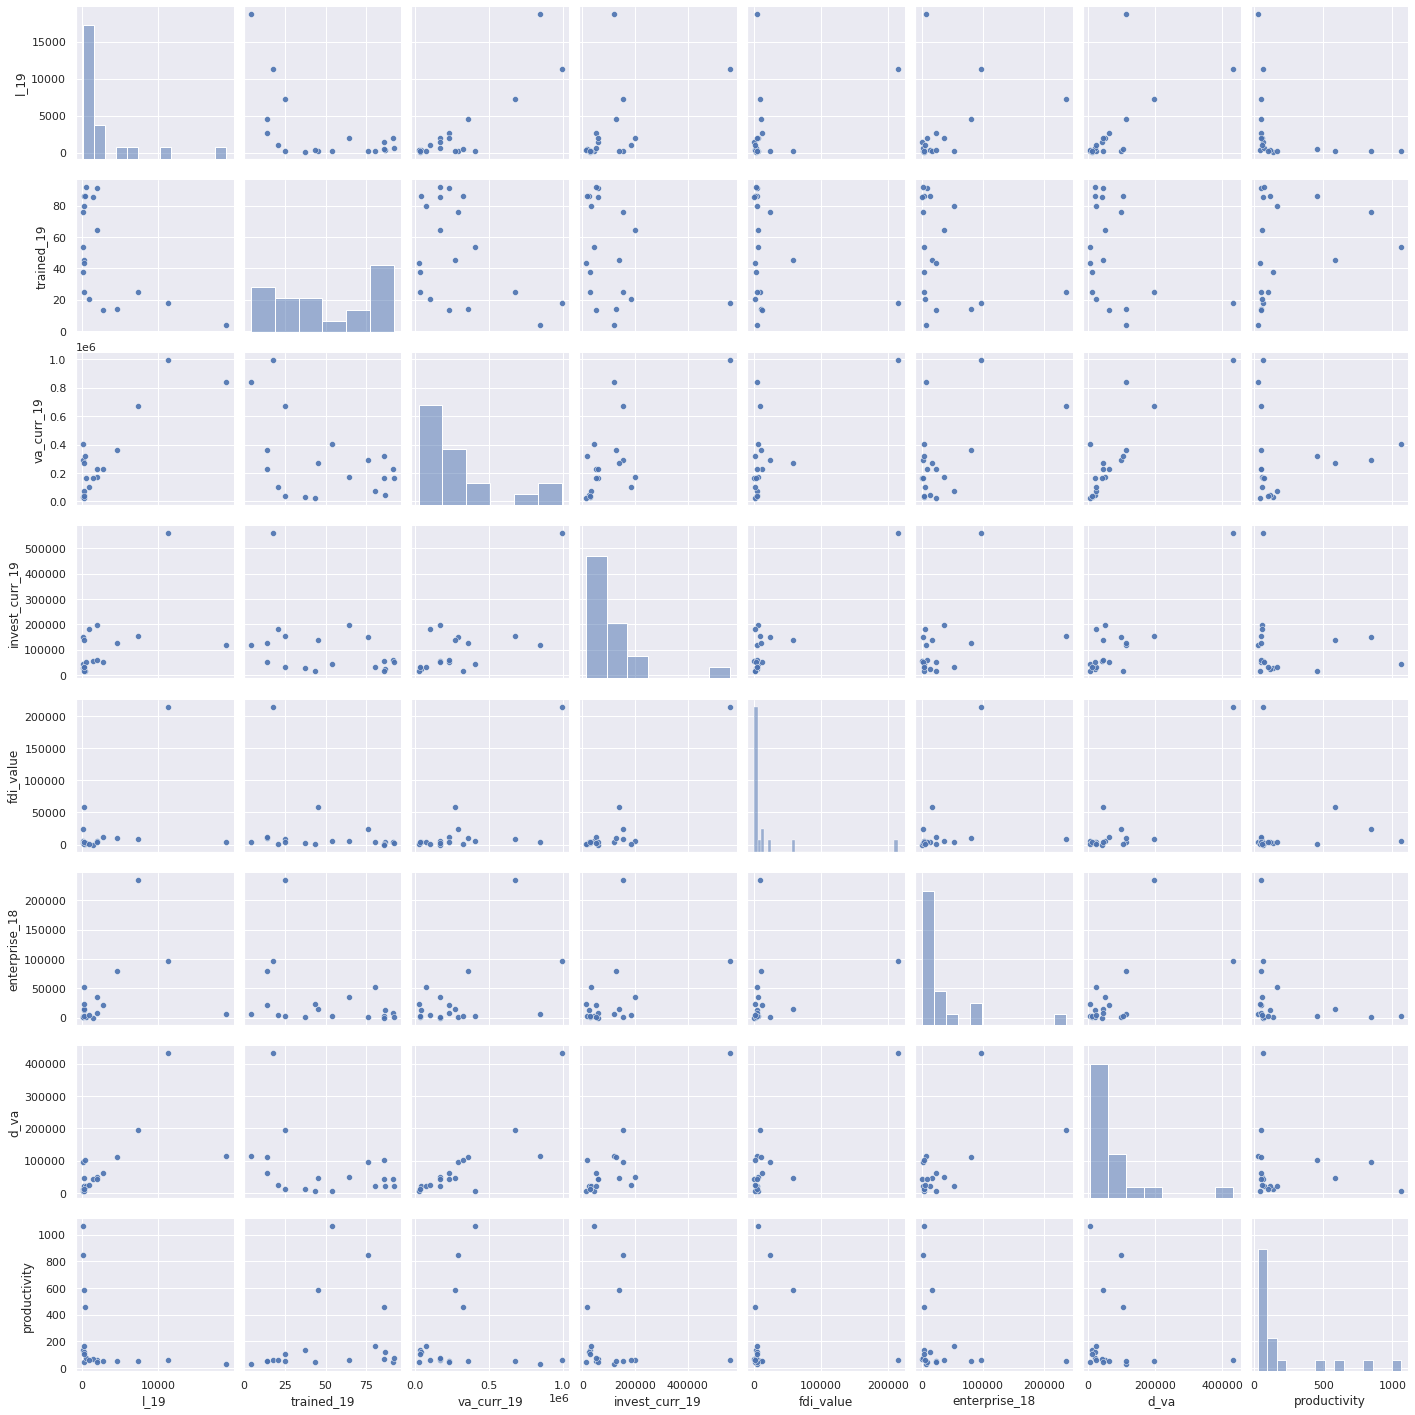

In [16]:
# pair plot: scatter
sns.pairplot(
    data=data_df,
    # hue='cluster', palette='muted',
    kind='scatter',
    diag_kind='auto',
    plot_kws={'alpha': 0.9},
    diag_kws={'alpha': 0.5}
)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig2')
plt.show()

## Hopkins statistic

In [18]:
# hopkins statistic
print('hopkins stat: {}'.format(hopkins(X_scaled, X_scaled.shape[0])))

hopkins stat: 0.28305045631488324


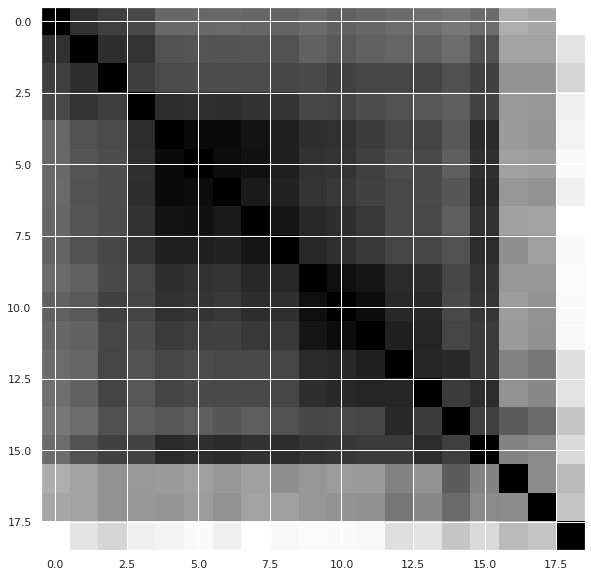

In [19]:
# vat
vat(X_scaled)

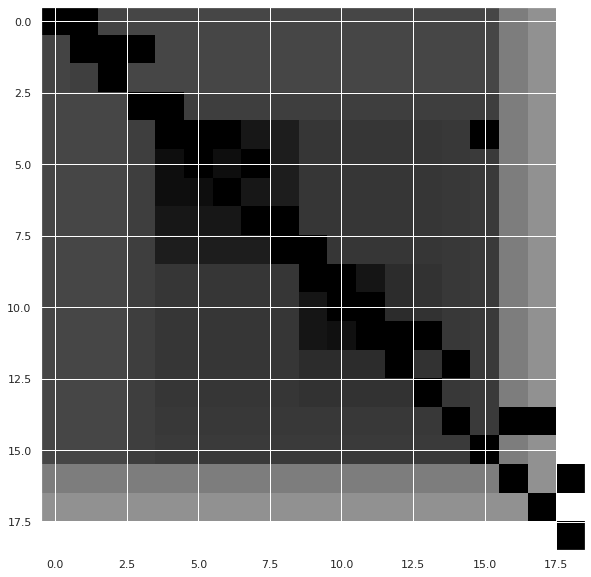

In [20]:
# ivat
ivat(X_scaled)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig3')

## Dendrogram

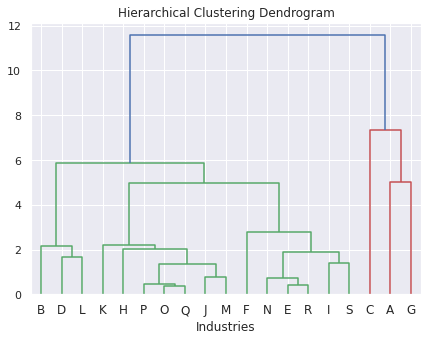

In [21]:
# dendrogram
Z = linkage(X_scaled, method='ward') # linkage matrix

plt.figure(figsize=(7, 5))
# dn = dendrogram(Z)
dn = dendrogram(Z, labels=data_df.index)
# dn = dendrogram(Z, p=5, truncate_mode='level', labels=data_df.index) # top 5 levels

# plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.xlabel('Industries')
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig4')
plt.show()

# PCA

In [22]:
# pca
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Scree plot

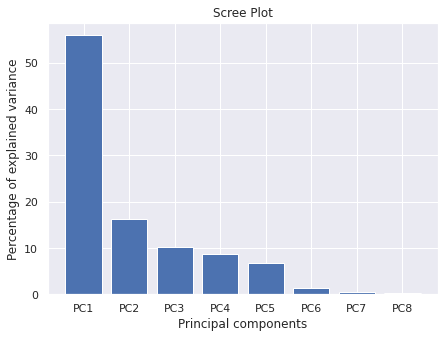

In [24]:
# PCs explained variance ratio => scree plot
PC_explained = pca.explained_variance_ratio_
PC_explained = np.round(100*PC_explained, decimals=1)

plt.figure(figsize=(7, 5))
tick_label = ['PC' + str(i) for i in range(1, len(PC_explained) + 1)]

plt.bar(
    x=range(1, len(PC_explained) + 1),
    height=PC_explained,
    tick_label=tick_label
)

plt.xlabel('Principal components')
plt.ylabel('Percentage of explained variance')
plt.title('Scree Plot')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig5')
plt.show()

## PCA graph

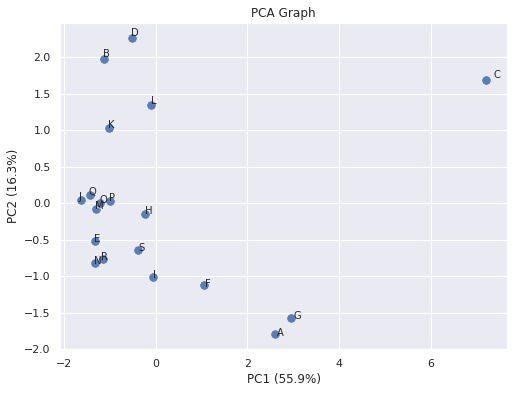

In [25]:
# PCA graph
X_scaled_pca = pca.transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_scaled_pca[:, 0],
    y=X_scaled_pca[:, 1],
    s=90,
    alpha=0.9
)

for i in range(len(X_scaled_pca)):
    plt.annotate(
        data_df.index[i],
        xy=(X_scaled_pca[i, 0], X_scaled_pca[i, 1]),
        textcoords='offset pixels'
    )

plt.xlabel('PC1 ({}%)'.format(PC_explained[0]))
plt.ylabel('PC2 ({}%)'.format(PC_explained[1]))
plt.title('PCA Graph')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig6')
plt.show()

## Loading scores

In [26]:
# loading scores (eigenvector) of PC1
loading_scores = pca.components_
PC1_loading_scores = np.abs(loading_scores[0, :]) # PC1

PC1_loading_scores = pd.Series(
    data=PC1_loading_scores,
    index=data_df.columns
)

print(PC1_loading_scores)

l_19              0.370550
trained_19        0.272080
va_curr_19        0.426279
invest_curr_19    0.414494
fdi_value         0.378079
enterprise_18     0.286236
d_va              0.447750
productivity      0.098949
dtype: float64


In [27]:
# sort PC1 loading scores
sorted = PC1_loading_scores.sort_values(ascending=False)

print(sorted)

d_va              0.447750
va_curr_19        0.426279
invest_curr_19    0.414494
fdi_value         0.378079
l_19              0.370550
enterprise_18     0.286236
trained_19        0.272080
productivity      0.098949
dtype: float64


# K-means
- n_cluster=3, 4

## Number of clusters

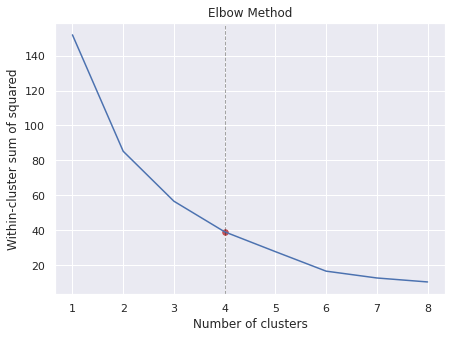

In [29]:
# elbow method
WSS = []
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    WSS_k = kmeans.inertia_
    WSS.append(WSS_k)

plt.figure(figsize=(7, 5))
sns.lineplot(
    x=range(1, len(WSS) + 1),
    y=WSS
)

# plt.vlines(
#     x=4,
#     ymin=0,
#     ymax=np.max(WSS),
#     colors='k',
#     linestyles='dashed',
#     alpha=0.5
# )

plt.axvline(
    x=4,
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)

plt.scatter(
    x=4,
    y=WSS[3],
    c='r', s=30
)

plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squared')
plt.title('Elbow Method')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig7')
plt.show()

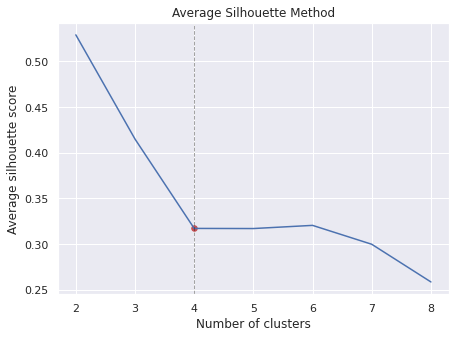

In [30]:
# average silhouette method
AS = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    AS_k = silhouette_score(X_scaled, kmeans.predict(X_scaled))
    AS.append(AS_k)

plt.figure(figsize=(7, 5))
sns.lineplot(
    x=range(2, 9),
    y=AS
)

# plt.vlines(
#     x=4,
#     ymin=0,
#     ymax=np.max(AS),
#     colors='k',
#     linestyles='dashed',
#     alpha=0.5
# )

plt.axvline(
    x=4,
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)

plt.scatter(
    x=4,
    y=AS[2],
    c='r', s=30
)

plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.title('Average Silhouette Method')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig8')
plt.show()

## K-means clustering

In [31]:
# k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [32]:
# cluster centers
centers = kmeans.cluster_centers_

In [33]:
# evaluate: silhouette score
labels = kmeans.predict(X_scaled)
AS = silhouette_score(X_scaled, labels)

print('average silhouuette: {}'.format(AS))

average silhouuette: 0.31698030660308274


## Plot k-means

In [34]:
# X_scaled_pca_df => PCA graph
X_scaled_pca_df = pd.DataFrame(
    data=X_scaled_pca[:, :2],
    index=data_df.index,
    columns=['PC1', 'PC2']
)

X_scaled_pca_df['cluster'] = labels + 1

X_scaled_pca_df['d_va'] = data_df['d_va'].values

centers=kmeans.cluster_centers_
centers=pca.transform(centers)
X_scaled_pca_df['cen_PC1'] = X_scaled_pca_df['cluster'].map({1: centers[0, 0], 2: centers[1, 0], 3: centers[2, 0], 4: centers[3, 0]})
X_scaled_pca_df['cen_PC2'] = X_scaled_pca_df['cluster'].map({1: centers[0, 1], 2: centers[1, 1], 3: centers[2, 1], 4: centers[3, 1]})

X_scaled_pca_df.head()

,PC1,PC2,cluster,d_va,cen_PC1,cen_PC2
ind_code,,,,,,
A,2.591795,-1.798649,3,114056.0,2.196978,-1.497925
B,-1.134429,1.974788,4,5920.0,-0.690952,1.651962
C,7.211257,1.694760,2,433087.0,7.211257,1.694760
D,-0.516669,2.264644,4,97364.0,-0.690952,1.651962
E,-1.316285,-0.519708,1,11055.0,-1.003489,-0.346258


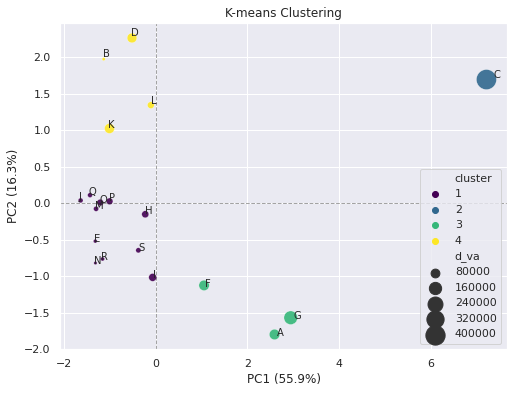

In [35]:
# (1) visualize clusters
## data
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_scaled_pca_df,
    x='PC1',
    y='PC2',
    hue='cluster', palette='viridis',
    size='d_va', sizes=(10, 400),
    # s=30,
    alpha=0.9
)

## average lines
plt.axvline(
    x=np.mean(X_scaled_pca_df['PC1']),
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)
plt.axhline(
    y=np.mean(X_scaled_pca_df['PC2']),
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)

## annotation
for i in range(X_scaled_pca_df.shape[0]):
    plt.annotate(
        X_scaled_pca_df.index[i],
        xy=(X_scaled_pca_df['PC1'][i], X_scaled_pca_df['PC2'][i]),
        textcoords='offset pixels'
    )

plt.xlabel('PC1 ({}%)'.format(PC_explained[0]))
plt.ylabel('PC2 ({}%)'.format(PC_explained[1]))
plt.legend()
plt.title('K-means Clustering')
plt.show()

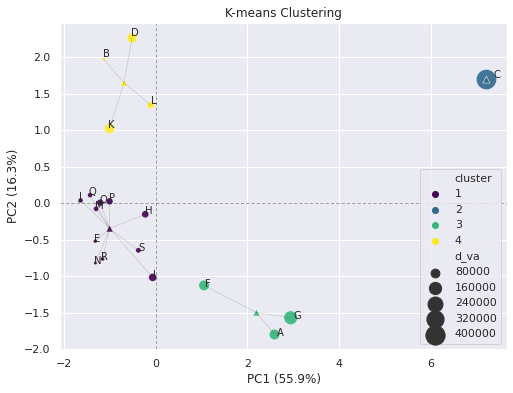

In [36]:
# (2) visualize clusters + centers
## data
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_scaled_pca_df,
    x='PC1',
    y='PC2',
    hue='cluster', palette='viridis',
    size='d_va', sizes=(10, 400),
    # s=30,
    alpha=0.9
)

## centers
centers=kmeans.cluster_centers_
centers=pca.transform(centers)
sns.scatterplot(
    x=centers[:, 0],
    y=centers[:, 1],
    hue=np.unique(labels), palette='viridis',
    s=50,
    marker='^',
    alpha=0.9,
    legend=False
)

for i, val in X_scaled_pca_df.iterrows():
    x=[val['PC1'], val['cen_PC1']]
    y=[val['PC2'], val['cen_PC2']]
    plt.plot(x, y, c='k', lw=0.3, alpha=0.4)

## average lines
plt.axvline(
    x=np.mean(X_scaled_pca_df['PC1']),
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)
plt.axhline(
    y=np.mean(X_scaled_pca_df['PC2']),
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)

## annotation
for i in range(X_scaled_pca_df.shape[0]):
    plt.annotate(
        X_scaled_pca_df.index[i],
        xy=(X_scaled_pca_df['PC1'][i], X_scaled_pca_df['PC2'][i]),
        textcoords='offset pixels'
    )

plt.xlabel('PC1 ({}%)'.format(PC_explained[0]))
plt.ylabel('PC2 ({}%)'.format(PC_explained[1]))
plt.legend()
plt.title('K-means Clustering')
plt.show()

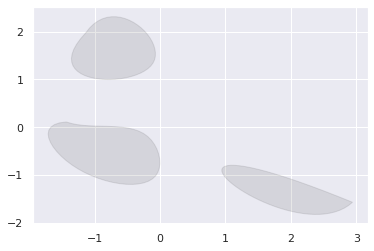

In [37]:
# https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
# from scipy.spatial import ConvexHull
# from scipy import interpolate

for i in [1, 3, 4]:
    points = X_scaled_pca_df.loc[X_scaled_pca_df['cluster'] == i][['PC1', 'PC2']].values
    
    # get convex hull
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0]) # get x coordinates
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0]) # get y coordinates

    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)

    plt.fill(interp_x, interp_y, '--', c='k', alpha=0.1)

plt.show()

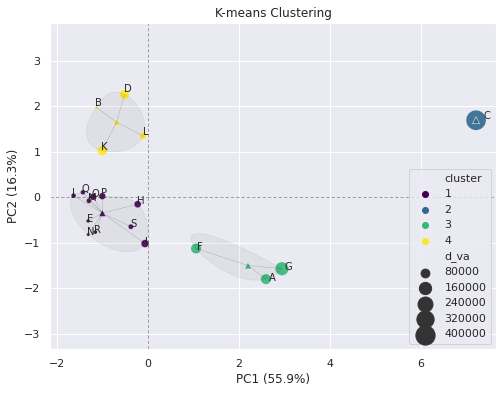

In [38]:
# (3) visualize clusters + centers + convex hull
## data
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=X_scaled_pca_df,
    x='PC1',
    y='PC2',
    hue='cluster', palette='viridis',
    size='d_va', sizes=(10, 400),
    # s=30,
    alpha=0.9,
    legend='brief'
)

## centers
centers=kmeans.cluster_centers_
centers=pca.transform(centers)
sns.scatterplot(
    x=centers[:, 0],
    y=centers[:, 1],
    hue=np.unique(labels), palette='viridis',
    s=50,
    marker='^',
    alpha=0.9,
    legend=False
)

for i, val in X_scaled_pca_df.iterrows():
    x=[val['PC1'], val['cen_PC1']]
    y=[val['PC2'], val['cen_PC2']]
    plt.plot(x, y, c='k', lw=0.3, alpha=0.4)

## convex hull
for i in [1, 3, 4]:
    points = X_scaled_pca_df.loc[X_scaled_pca_df['cluster'] == i][['PC1', 'PC2']].values
    
    # get convex hull
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0]) # get x coordinates
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0]) # get y coordinates

    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)

    plt.fill(interp_x, interp_y, '--', c='k', alpha=0.05)

## average lines
plt.axvline(
    x=np.mean(X_scaled_pca_df['PC1']),
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)
plt.axhline(
    y=np.mean(X_scaled_pca_df['PC2']),
    c='k',
    ls='--',
    lw=1,
    alpha=0.4
)

## annotation
for i in range(X_scaled_pca_df.shape[0]):
    plt.annotate(
        X_scaled_pca_df.index[i],
        xy=(X_scaled_pca_df['PC1'][i], X_scaled_pca_df['PC2'][i]),
        textcoords='offset pixels'
    )

plt.xlabel('PC1 ({}%)'.format(PC_explained[0]))
plt.ylabel('PC2 ({}%)'.format(PC_explained[1]))
plt.axis('equal')
plt.legend()
plt.title('K-means Clustering')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig9.png')
plt.show()

# Visualize clusters

In [39]:
# add cluster
data_df['cluster'] = labels + 1
data_df['cluster'] = data_df['cluster'].map({1:'(others)', 2: '(C)', 3: '(AFG)', 4: '(BDKL)'})

In [40]:
# sorted features
features = sorted.index.tolist()

print(features)

['d_va', 'va_curr_19', 'invest_curr_19', 'fdi_value', 'l_19', 'enterprise_18', 'trained_19', 'productivity']


In [41]:
# cluster_df
cluster_df = data_df.groupby('cluster').mean()
cluster_df

,l_19,trained_19,va_curr_19,invest_curr_19,fdi_value,enterprise_18,d_va,productivity
cluster,,,,,,,,
(AFG),10242.166667,14.400000,625048.666667,133720.333333,7359.666667,107415.333333,140820.666667,43.609893
(BDKL),294.175000,65.450000,322715.000000,88121.250000,21953.325000,5937.500000,62980.500000,737.044208
(C),11287.600000,17.700000,995126.000000,559708.000000,214610.400000,96715.000000,433087.000000,63.117669
(others),1021.600000,58.263636,115233.090909,66680.363636,3527.900000,15266.000000,29125.363636,83.199057


## Bar plots

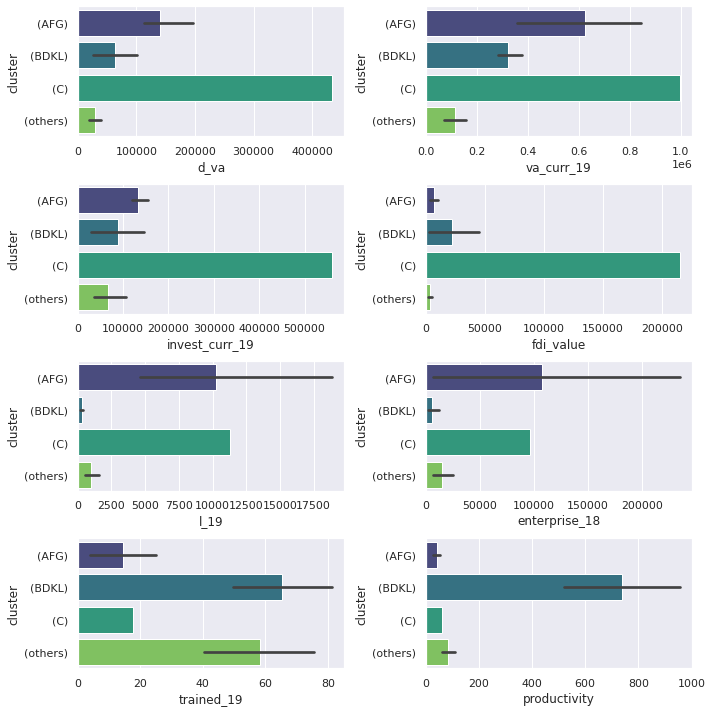

In [42]:
# 8 bar plots
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(10, 10)
)

for feature, ax in zip(features, axes.flatten()):
    sns.barplot(
        data=data_df,
        x=feature,
        y='cluster',
        palette='viridis',
        ax=ax
    )

plt.tight_layout()
plt.show()

## Bar + box + KDE plots

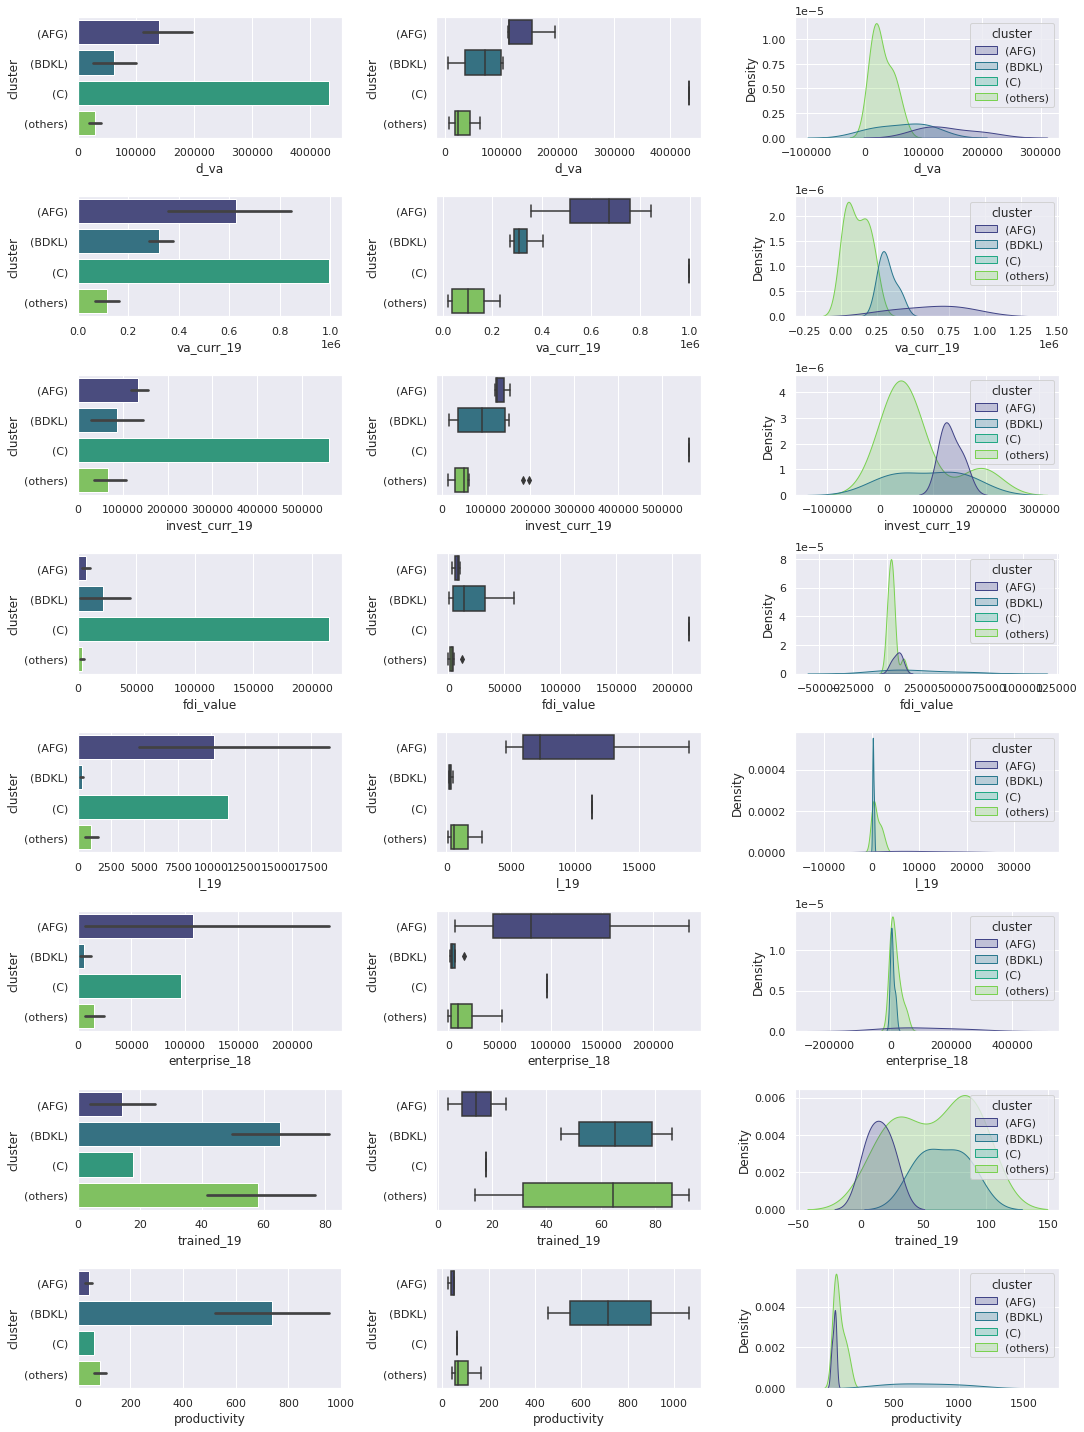

In [43]:
# 8 bar + box + kde plots
fig, axes = plt.subplots(
    nrows=8,
    ncols=3,
    figsize=(15, 20)
)

for feature, ax in zip(features, axes):
    sns.barplot(
        data=data_df,
        x=feature,
        y='cluster',
        palette='viridis',
        ax=ax[0]
    )
    
    sns.boxplot(
        data=data_df,
        x=feature,
        y='cluster',
        palette='viridis',
        ax=ax[1]
    )

    sns.kdeplot(
        data=data_df,
        x=feature,
        shade=True,
        hue='cluster', palette='viridis',
        # legend=False,
        ax=ax[2]
    )

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig10.png')
plt.show()

## Scatter plots

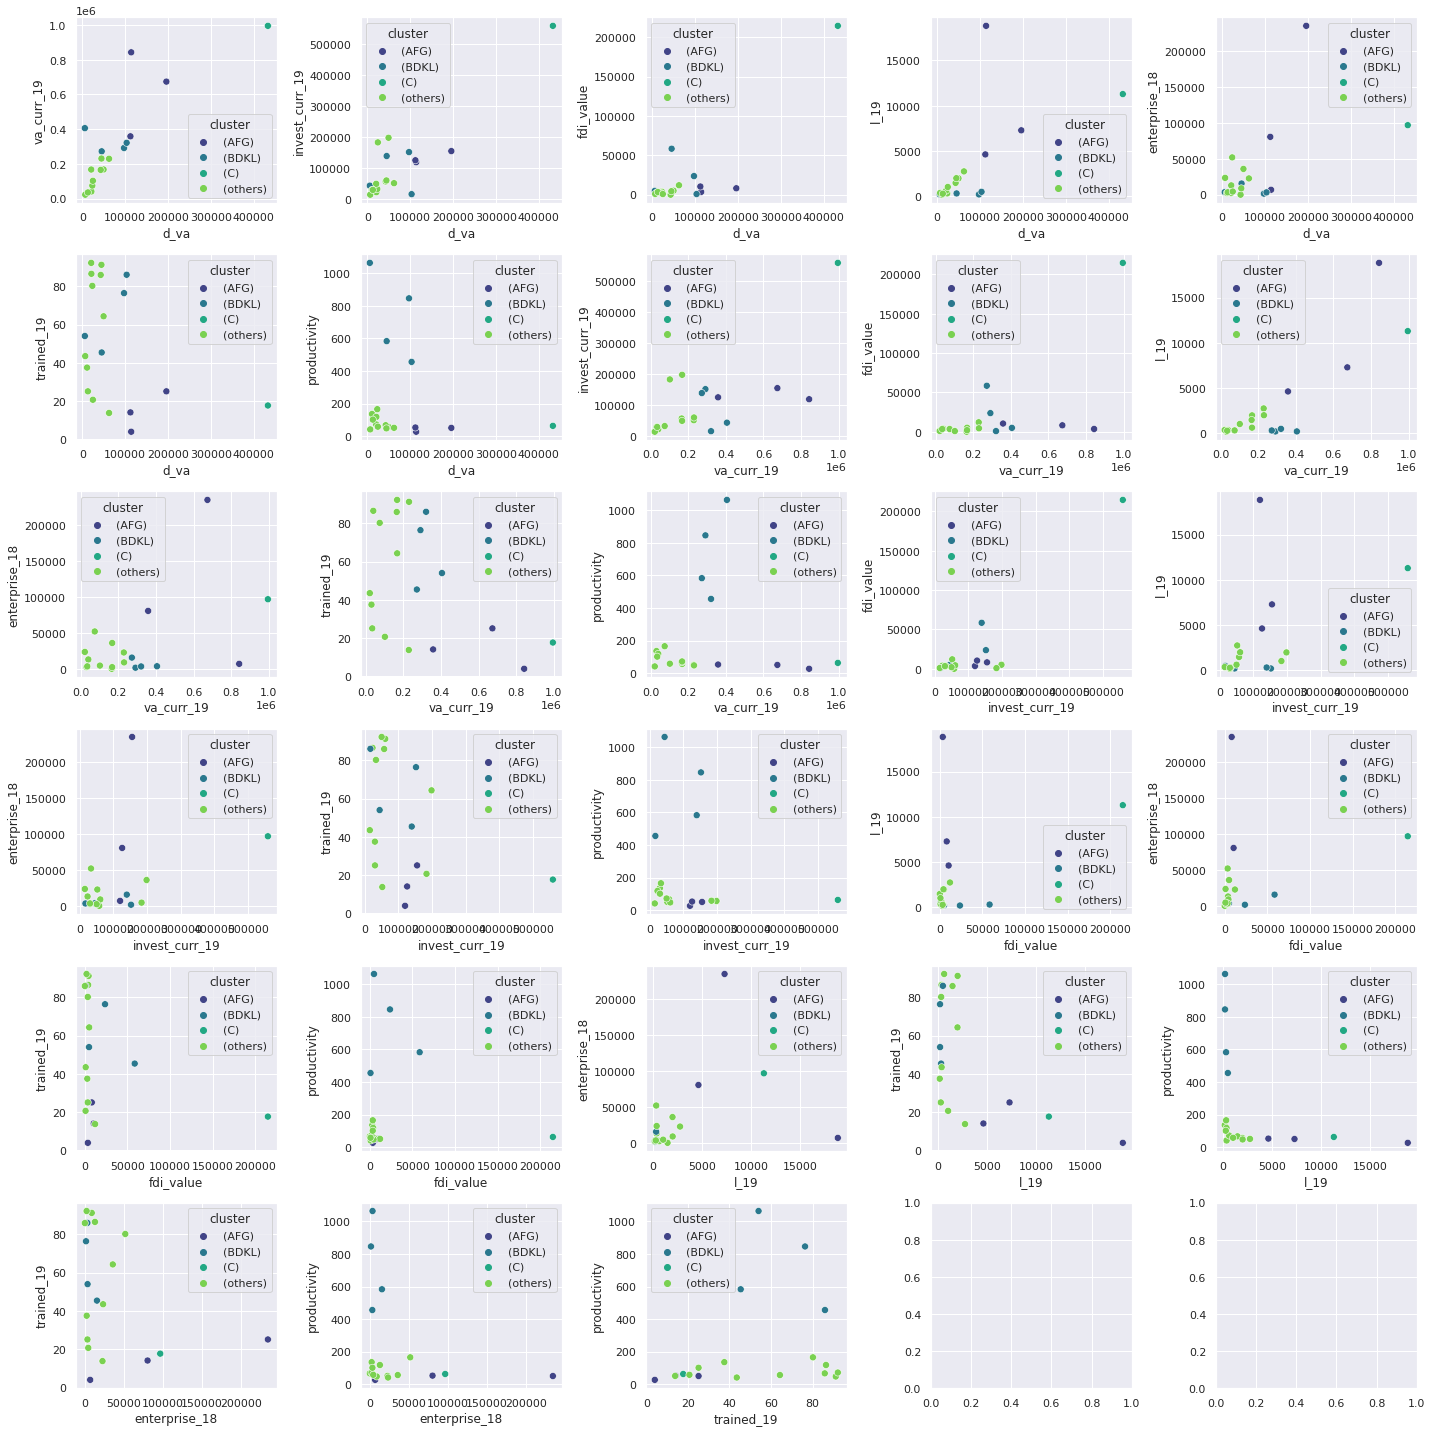

In [44]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))

for i, ax in zip(combinations(features, r=2), axes.flatten()):
    # for j in data_scaled_df['cluster'].unique():
    #     filt_df = data_scaled_df.loc[data_scaled_df['cluster'] == j]
    #     ax.scatter(x=filt_df[i[0]], y=filt_df[i[1]], s=20, label=j)
    #     ax.set_xlabel(i[0])
    #     ax.set_ylabel(i[1])
    #     ax.legend()
    
    sns.scatterplot(
        data=data_df,
        x=data_df[i[0]],
        y=data_df[i[1]],
        hue='cluster', palette='viridis',
        s=50,
        ax=ax
    )

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig11.png')
plt.show()

## Pair plots

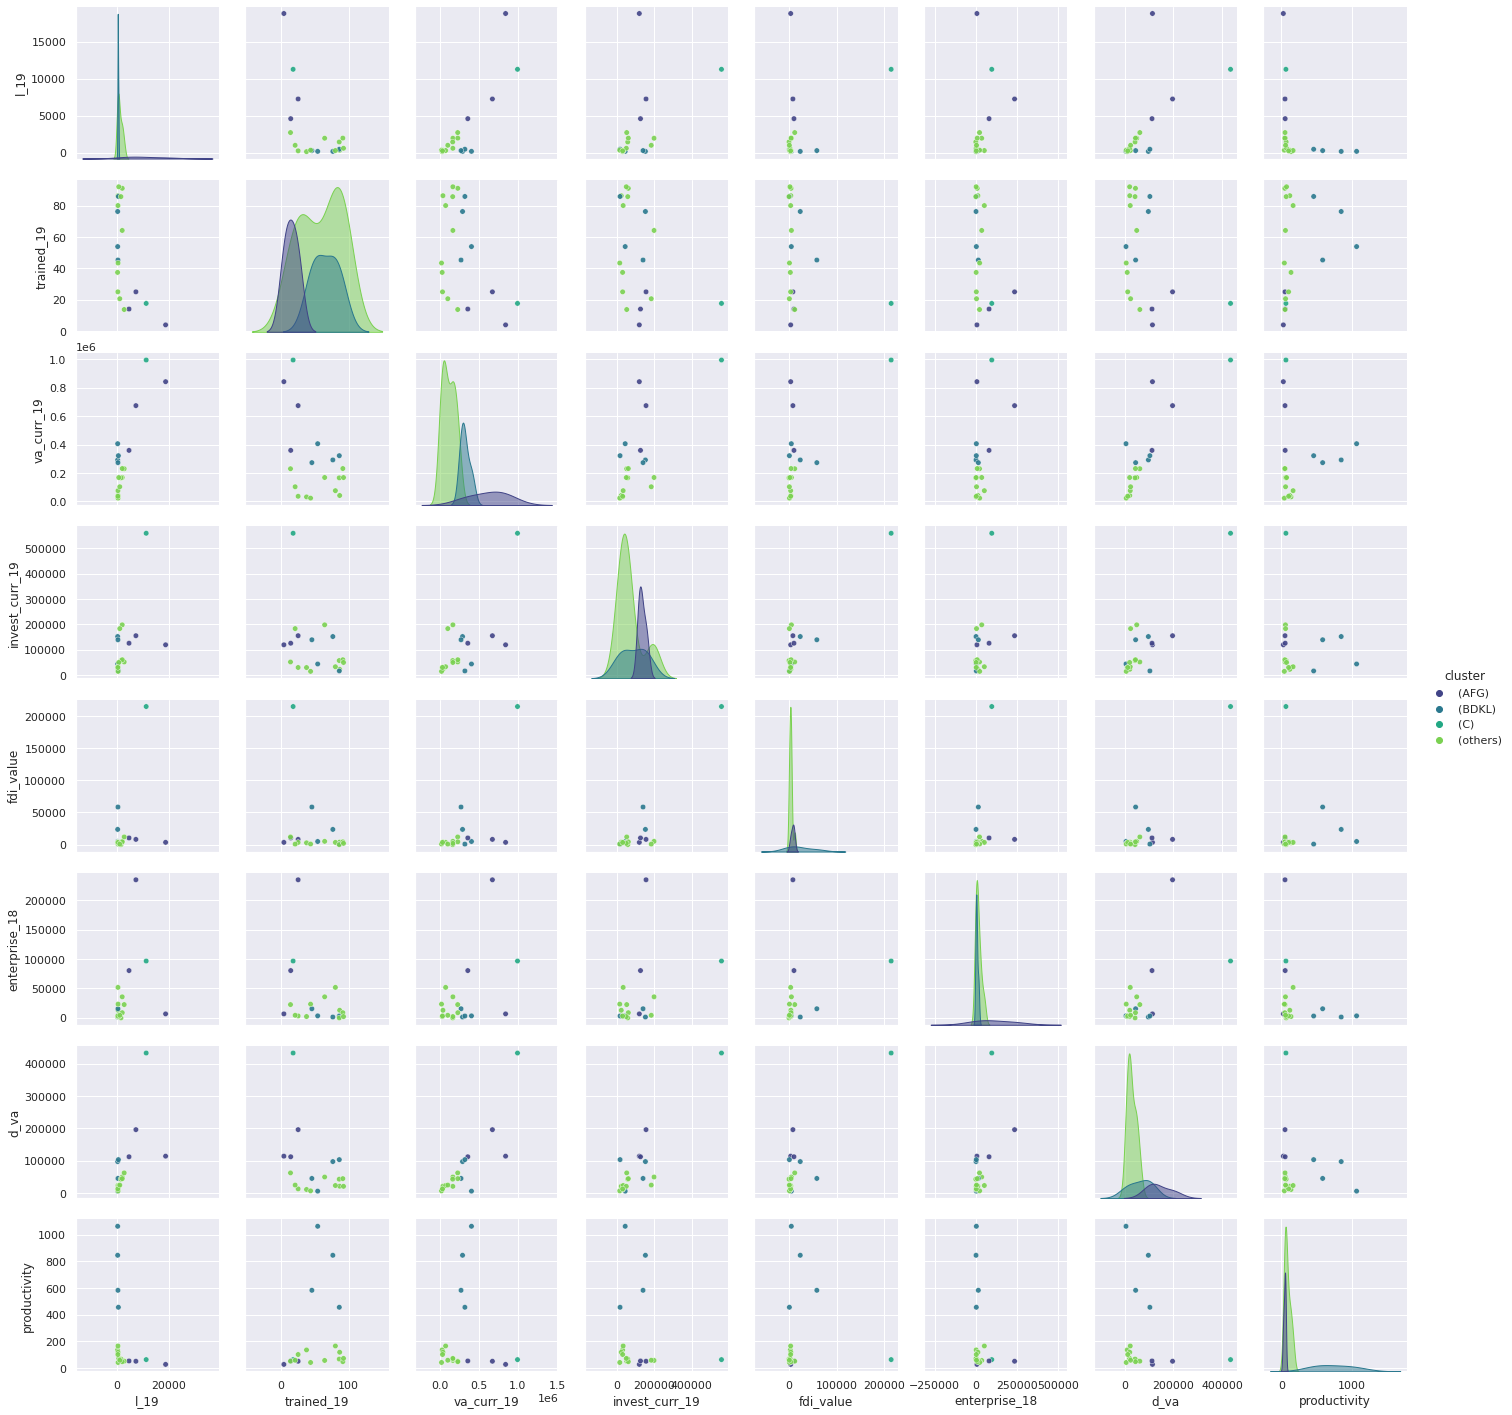

In [45]:
# pair plot: scatter (with cluster)
sns.pairplot(
    data=data_df,
    hue='cluster', palette='viridis',
    kind='scatter',
    diag_kind='auto',
    plot_kws={'s': 30, 'alpha': 0.9},
    diag_kws={'alpha': 0.5}
)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/practices/industries_clustering/figure/fig12.png')
plt.show()